This notebook is part of the supplementary material of the work.


**Related Reference:** "GPU-optimized Matrix Method for Phase Retrieval with the Transport of Intensity Equation" Alejandro Silva and Julia Alonso.

Last modified on 10/10/2024


Recomendations:

- IT IS STRONGLY RECOMMENDED TO RUN THIS ON GOOGLE COLAB

- We recommend running the code twice to avoid delays in the GPU connection.



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 2.1. Study of the behavior of the approximating functions.


The Tikhonov regularization parameter is based on the following approximation:

$\frac{1}{\omega^2} \approx \frac{\omega^2}{\omega_c^4 + \omega^4}$

where

$\omega_c^4 = \frac{r}{px^4}$




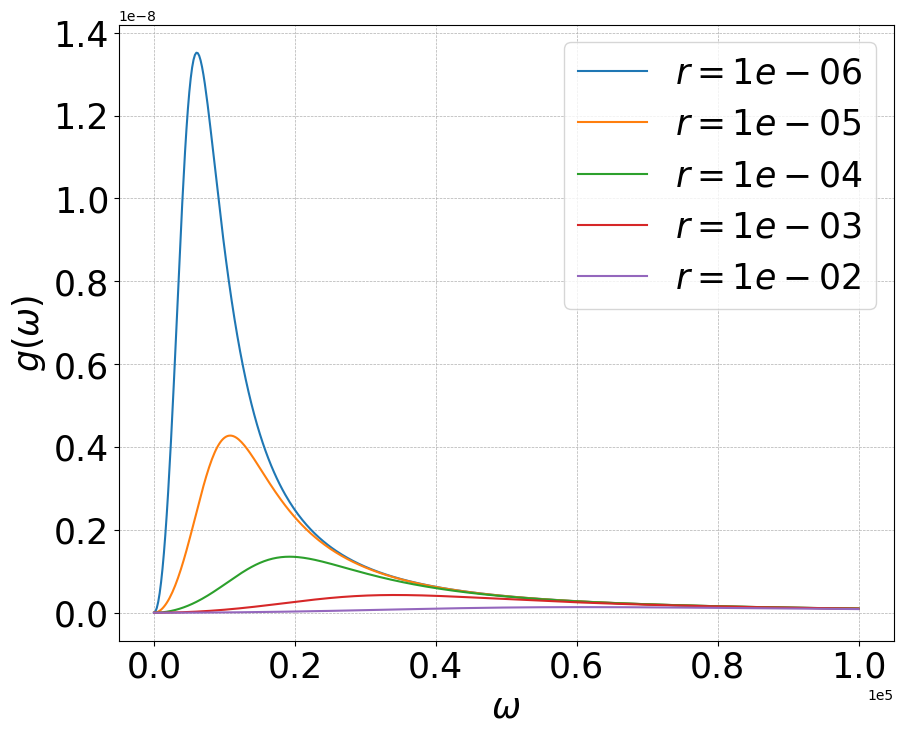

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# pixel size
px = 5.2e-6

r_values = [10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2)]

#  ω != 0 !!
omega = np.linspace(0, 100000, 500)

plt.figure(figsize=(10, 8))

for r in r_values:
    omega_c = (r**(1/4)) / px
    g = omega**2 / (omega_c**4 + omega**4)
    plt.plot(omega, g, label=rf'$r = {r:.0e}$')

# Personalización del gráfico
plt.xlabel(r'$\omega$', fontsize=25)
plt.ylabel(r'$g(\omega)$', fontsize=25)
plt.legend(fontsize=25)
plt.grid(True, linestyle="--", linewidth=0.5)
#plt.title("Behavior of the approximated function for different values of r", fontsize=16)

# Ajuste de notación científica para los ejes
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.rcParams['font.size'] = 25

plt.show()


Ahora vamos a probar una función diferente

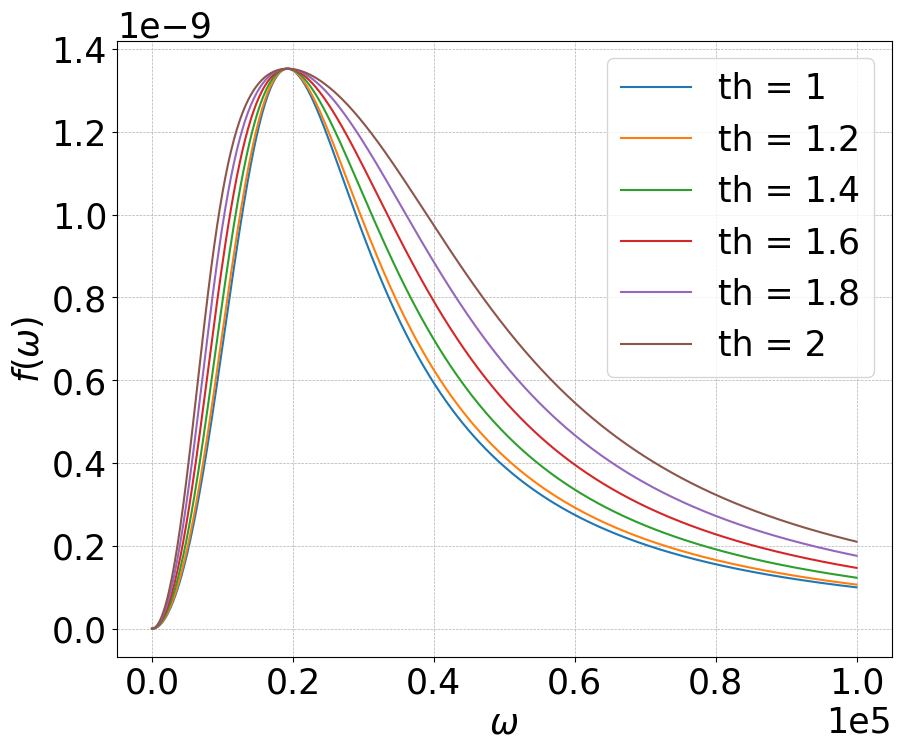

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameter
px = 5.2e-6
r = 1e-4

# Define the range of omega, avoiding ω=0 to prevent division by zero
omega = np.linspace(0, 100000, 500)

# Plot
plt.figure(figsize=(10, 8))


omega_c = (r**(1/4)) / px

g = omega**2 / (omega_c**4 + omega**4)

plt.plot(omega, g, label=f'th = {1}')
#plt.plot(omega, g, label=rf'$g = \omega^2 / [(\omega_c^4 + \omega^4)]$')

for th in [1.2, 1.4,1.6,1.8,2]:
    omega_c1 = omega_c / th
    omega_c2 = omega_c * th

    f = omega**2 / ((omega)**2 - 1j*omega_c1**2) / (omega**2 + 1j*omega_c2**2)
    f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)
    plt.plot(omega, np.abs(f), label=f'th = {th}')

plt.xlabel(r'$\omega$', fontsize=25)
plt.ylabel(r'$f(\omega)$', fontsize=25)
plt.legend(fontsize=25)
plt.grid(True, linestyle="--", linewidth=0.5)
# plt.title("Behavior of the approximated function for different values of th")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.rcParams['font.size'] = 25

plt.show()


From the previous graph, we can observe that the function


$g(\omega) = \frac{ \omega^2 }{ \omega_c^4 + \omega^4}$

has the same behavior as the function $f(\omega)$, provided that the condition $\omega_c^2 = \omega_{c1}\omega_{c2}$ is satisfied.

$f(\omega) = \left( \frac{ \omega_{c1 } ^2 + \omega_{c2}^2}{2 * \omega_{c1} \cdot \omega_{c2} } \right) \cdot \left(\frac{\omega^2 }{ (-j\omega_c^2 + \omega^2)(j\omega_c^2 + \omega^2)} \right)$


Thus, it becomes convenient to take particular values as follows:

$\omega_{c1} = \omega_{c}/th $
$\omega_{c2} = \omega_{c} \cdot th $

where $th$ allows us to adjust the width of the bell, making it wider.


# Simulations

 ## funcions

In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from tqdm import tqdm
import time
from math import comb
import cupy as cp
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import filters, measure
import os
import pandas as pd
import numpy as np
from skimage import img_as_float
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim

In [5]:
path_repo = "/content/drive/My Drive/Doctorado/Papers_Propios/Paper-OptimalRegularization2025/ems-tie-repo"

print(os.listdir(path_repo))

['notebook', 'data']


**Propagation of the complex electric field**

In [6]:
def numerical_propagation(U0z, dz, pixelsize, lambda_, method):
    if method == 'Angular Spectrum':
        k = 2 * cp.pi / lambda_
        Nx, Ny = U0z.shape
        fx = cp.fft.fftfreq(Nx, pixelsize)
        fy = cp.fft.fftfreq(Ny, pixelsize)
        FX, FY = cp.meshgrid(fx, fy)
        H = cp.exp(1j * dz * cp.sqrt(k**2 - (2 * cp.pi * FX)**2 - (2 * cp.pi * FY)**2))
        U1z = cp.fft.ifft2(cp.fft.fft2(U0z) * H)
        I1z = cp.abs(U1z)**2
        return U1z, I1z


**Universal Solution Method (US-TIE)**

In [7]:
def TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method):
    J = -k * dIdz_curr
    Ny, Nx = J.shape
    Lambda = 2 * cp.pi / k
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Nx, Pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Ny, Pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)

    # Calculate phi assuming uniform intensity.
    FJ = cp.fft.fft2(J / cp.max(I0))
    Fphi = FJ * (Cx * Cx + Cy * Cy) / (r / Pixelsize ** 4 + (Cx * Cx + Cy * Cy) ** 2)
    Phi = cp.real(cp.fft.ifft2(Fphi))

    if Method == 'TIE':
        # Calculate the estimate of dIdz using TIE
        Fdphidx = Fphi * Cx
        Fdphidy = Fphi * Cy
        dphidx = cp.real(cp.fft.ifft2(Fdphidx))
        dphidy = cp.real(cp.fft.ifft2(Fdphidy))
        dPsidx = I0 * dphidx
        dPsidy = I0 * dphidy
        FdPsidx = cp.fft.fft2(dPsidx)
        FdPsidy = cp.fft.fft2(dPsidy)
        Fd2Psidx2 = FdPsidx * Cx
        Fd2Psidy2 = FdPsidy * Cy
        d2Psidx2 = cp.real(cp.fft.ifft2(Fd2Psidx2))
        d2Psidy2 = cp.real(cp.fft.ifft2(Fd2Psidy2))
        laplacePsi = d2Psidx2 + d2Psidy2
        # Estimate dIdz
        dIdz_est = laplacePsi / (-k)

    elif Method == 'Angular Spectrum':
        # Calculate the estimate of dIdz using Angular Spectrum
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        Exp_term = cp.sqrt(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2)
        H = cp.exp(1j * k * dz * Exp_term)
        H[(1 - (Lambda * U) ** 2 - (Lambda * V) ** 2) < 0] = 0  # neglect evanescent wave
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    elif Method == 'Fresnel':
        # Calculate the estimate of dIdz using Fresnel method
        FU = cp.fft.fftshift(cp.fft.fft2(cp.sqrt(I0) * cp.exp(1j * (Phi + Phi_curr))))
        H = cp.exp(1j * k * dz * (1 - ((Lambda * U) ** 2 + (Lambda * V) ** 2) / 2))
        Uz = cp.fft.ifft2(cp.fft.ifftshift(FU * H))
        Iz = Uz * cp.conj(Uz)
        dIdz_est = (Iz - I0) / dz

    else:
        raise ValueError("Type of transfer function must be 'Angular Spectrum' or 'Fresnel'")

    return Phi, dIdz_est



def US_TIE(dIdz, dz, I0, Pixelsize, k, r, Iter, JudgeFlag, Method='TIE', True_phase=None):
    if Method not in ['TIE', 'Angular Spectrum', 'Fresnel']:
        raise ValueError("Currently 'Method' only allows 'TIE', 'Angular Spectrum' or 'Fresnel'.")

    RMSE = []
    Time = []

    dIdz_curr = cp.array(dIdz)
    dIdz_temp = cp.array(dIdz)

    Phi_curr = cp.zeros_like(dIdz_curr)

    if True_phase is not None:
        err = Phi_curr - cp.array(True_phase)
        err = err - cp.mean(err[~cp.isnan(err)])
        valid_elements = ~cp.isnan(err)
        RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
        RMSE.append(RMSE_Temp)

    for n in range(1, Iter + 1):
        # Estimate Phase with TIE_MAX_solver
        t0 = time.time()
        Phi_est, dIdz_est = TIE_MAX_solver(Phi_curr, dIdz_curr, dz, I0, Pixelsize, k, r, Method)
        t1 = time.time()
        t2 = t1 - t0
        dIdz_temp = dIdz_curr

        # Calculate dIdz Error
        if Method == 'TIE':
            dIdz_curr = dIdz_curr - dIdz_est
        elif Method in ['Fresnel', 'Angular Spectrum']:
            dIdz_curr = cp.array(dIdz) - dIdz_est

        # Current Phase Estimate
        Phi_curr = Phi_curr + Phi_est

        # Calculate RMSE
        if True_phase is not None:
            err = Phi_curr - cp.array(True_phase)
            err = err - cp.mean(err[~cp.isnan(err)])
            valid_elements = ~cp.isnan(err)
            RMSE_Temp = cp.sqrt(cp.sum(err[valid_elements] ** 2) / cp.sum(valid_elements))
            RMSE.append(RMSE_Temp)
            Time.append(t2)

        # Check Convergence
        if JudgeFlag:
            if (cp.max(dIdz_curr) < cp.max(cp.array(dIdz)) * 1e-3 or cp.max(dIdz_curr) > 1.05 * cp.max(dIdz_temp)):
                print(f'US-TIE iteration time: {n}')
                break
        if n == Iter:
            print(f'US-TIE iteration time: {Iter}')

    Phi = Phi_curr.get()
    return Phi, RMSE, Time



**Matrix Solution Method (MS-TIE)**

In [8]:
def conv2(A, B):
    """
    A es la fft
    """
    return cp.fft.fft2(A * cp.fft.ifft2(B, axes=(0, 1)), axes=(0, 1))

def MS_TIE(I0, pixelsize, dIdz, Iter, r,k, Method='TIE'):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    if Method == "TIE":
      Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      Filter_tie[:,:,0] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,1] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)
      Filter_tie[:,:,2] = (Cx * Cx + Cy * Cy) / (r / pixelsize**4 + (Cx * Cx + Cy * Cy)**2)

      I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      I[:,:,0] = I0
      I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
      I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

      M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      M[:,:,0] = (Cx * Cx + Cy * Cy)
      M[:,:,1] = Cx
      M[:,:,2] = Cy

      FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
      FJ = Filter_tie * FJ * (-k)

      Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
      M_ones = cp.ones((3, 3), dtype = cp.complex64)
      t1 = time.time()
      for n in range(Iter):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

      Fphi_curr += FJ
      time_exe = time.time() - t1
      return cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))), time_exe




In [9]:
def add_gaussian_noise(image, sigma):
    """
    Adds Gaussian noise to a normalized grayscale image.

    Args:
        image: The image to which noise will be added, normalized between 0 and 1.
        sigma: The standard deviation of the Gaussian noise.

    Returns:
        A new image with added noise, normalized between 0 and 1.
    """

    if not isinstance(image, cp.ndarray):
        image = cp.asarray(image)

    # Generate Gaussian noise with the same shape as the image and the specified sigma
    noise = cp.random.normal(loc=0, scale=sigma, size=image.shape)

    # Add the noise to the image
    noisy_image = image + noise

    # Ensure pixel values are within the [0, 1] range
    noisy_image = cp.clip(noisy_image, 0, 1)

    return noisy_image

def compute_rmse(Image,Phi):

  True_phase_fft = cp.asarray(Phi)
  err_fft = cp.asarray(Image) - True_phase_fft
  err_fft = err_fft - cp.nanmean(err_fft)
  valid_elements_fft = ~cp.isnan(err_fft)
  RMSE_fft = cp.sqrt(cp.sum(err_fft[valid_elements_fft]**2) / cp.sum(valid_elements_fft))
  return RMSE_fft.get()


def compute_psnr(rmse):

    # Calculate the Mean Squared Error (MSE)
    mse =rmse** 2

    # If MSE is zero, the images are identical (PSNR is infinite)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    max_pixel_value = 1.0  # For images normalized between 0 and 1
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)

    return psnr

def normalize_image(image):
    # Image to range [0, 1]
    return (image - image.min()) / (image.max() - image.min())

def compute_ssim(image1, image2, normalization=True):
    # Ensure the images are in float format for SSIM calculation
    if normalization:
        if hasattr(image1, 'get'):
            image1 = normalize_image(image1.get())
        else:
            image1 = normalize_image(image1)

        if hasattr(image2, 'get'):
            image2 = normalize_image(image2.get())
        else:
            image2 = normalize_image(image2)
    else:
        if hasattr(image1, 'get'):
            image1 = image1.get()

        if hasattr(image2, 'get'):
            image2 = image2.get()

    # Compute SSIM and specify the data range
    ssim_index, _ = ssim(image1, image2, full=True, data_range=1) #image2.max() - image2.min()

    return ssim_index

def compute_metrics_vector(I0, Phi, sigmas, parameters, method = "MS", th = 1.0):
    """
    Computes RMSE, PSNR, SSIM, and processing time for different levels of noise.

    Args:
        I0: The original image.
        Phi: The phase to be used in the image (if required).
        sigmas: A vector of sigma values for Gaussian noise.
        parameters: A tuple containing dz, pixelsize, k, r, and ITER for the calculation.
        method: The method to be used ("MS" for Method 1 or "US" for Method 2).

    Returns:
        A pandas DataFrame with columns ['RMSE', 'PSNR', 'SSIM', 'Time'] and rows for each sigma value.
    """

    dz, pixelsize, k, r, ITER = parameters

    rmse_values = []
    psnr_values = []
    ssim_values = []
    time_values = []

    U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
    Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')

    for sigma in sigmas:
        # Add Gaussian noise to the original image, only add noise to I0
        I0_noisy = cp.asarray(add_gaussian_noise(I0, sigma))
        dIdz = cp.asarray((Iz - I0_noisy) / dz)

        if method == "US":

            start_time = time.time()
            Phi_us_tie, _, _ = US_TIE(dIdz.copy(), dz, I0.copy(), pixelsize, k, r, ITER, 0, Method='TIE')
            end_time = time.time()
            time_us_tie = end_time - start_time
            rmse_values.append(compute_rmse(Phi_us_tie, Phi))
            psnr_values.append(compute_psnr(rmse_values[-1]))
            ssim_values.append(compute_ssim(Phi_us_tie, Phi))
            time_values.append(time_us_tie)

        elif method == "MS":
            Phi_ms_tie, time_ms_tie = MS_TIE(I0.copy(), pixelsize, dIdz.copy(), ITER, r, k)
            rmse_values.append(compute_rmse(Phi_ms_tie, Phi))
            psnr_values.append(compute_psnr(rmse_values[-1]))
            ssim_values.append(compute_ssim(Phi_ms_tie, Phi))
            time_values.append(time_ms_tie)
        elif method == "MSth":
            Phi_msth_tie, time_msth_tie = MS_TIE_th(I0.copy(), pixelsize, dIdz.copy(), ITER, r, k, th = th)
            rmse_values.append(compute_rmse(Phi_msth_tie, Phi))
            psnr_values.append(compute_psnr(rmse_values[-1]))
            ssim_values.append(compute_ssim(Phi_msth_tie, Phi))
            time_values.append(time_msth_tie)

        else:
            raise ValueError(f"Invalid method '{method}'. Choose 'MS' or 'US'.")

    # Return results as a DataFrame
    results_df = pd.DataFrame({
        'RMSE': rmse_values,
        'PSNR': psnr_values,
        'SSIM': ssim_values,
        'Time': time_values
    }, index=sigmas)

    return results_df

In [10]:

def MS_TIE_th(I0, pixelsize, dIdz, Iter, r,k, th = 1.0, Method='TIE'):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    if Method == "TIE":
      Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

      omega2 = Cx * Cx + Cy * Cy

      omega_c = (r**(1/4)) / pixelsize
      omega_c1 = omega_c / th
      omega_c2 = omega_c * th

      f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
      f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)


      Filter_tie[:,:,0] = -abs(f).copy()
      Filter_tie[:,:,1] = -abs(f).copy()
      Filter_tie[:,:,2] = -abs(f).copy()

      I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      I[:,:,0] = I0
      I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
      I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

      M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      M[:,:,0] = (Cx * Cx + Cy * Cy)
      M[:,:,1] = Cx
      M[:,:,2] = Cy

      FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
      FJ = Filter_tie * FJ * (-k)

      Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
      M_ones = cp.ones((3, 3), dtype = cp.complex64)
      t1 = time.time()
      for n in range(Iter):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

      Fphi_curr += FJ
      time_exe = time.time() - t1
      return cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))), time_exe


def get_spectrums(I0, pixelsize, dIdz, Iter, r,k, th = 1.0):

    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

    omega2 = Cx * Cx + Cy * Cy

    omega_c = (r**(1/4)) / pixelsize
    omega_c1 = omega_c / th
    omega_c2 = omega_c * th

    f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
    f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)


    Filter_tie[:,:,0] = -abs(f).copy()
    Filter_tie[:,:,1] = -abs(f).copy()
    Filter_tie[:,:,2] = -abs(f).copy()

    I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    I[:,:,0] = I0
    I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
    I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

    M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    M[:,:,0] = (Cx * Cx + Cy * Cy)
    M[:,:,1] = Cx
    M[:,:,2] = Cy

    FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
    FJ = Filter_tie * FJ * (-k)

    Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
    M_ones = cp.ones((3, 3), dtype = cp.complex64)
    t1 = time.time()
    FJs = []
    for n in range(Iter):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))
          FJs.append(cp.fft.ifftshift(Filter_tie[:,:,0]*FJ[:,:,0]))
    Fphi_curr += FJ
    return cp.fft.ifftshift(Filter_tie[:,:,0]), FJs, cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2)))



def get_reconstructionmap(I0, pixelsize, dIdz, Iter, r,k, th = 1.0):

    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)

    Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

    omega2 = Cx * Cx + Cy * Cy

    omega_c = (r**(1/4)) / pixelsize
    omega_c1 = omega_c / th
    omega_c2 = omega_c * th

    f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
    f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)

    Filter_tie[:,:,0] = -abs(f).copy()
    Filter_tie[:,:,1] = -abs(f).copy()
    Filter_tie[:,:,2] = -abs(f).copy()

    I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    I[:,:,0] = I0
    I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
    I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

    M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    M[:,:,0] = (Cx * Cx + Cy * Cy)
    M[:,:,1] = Cx
    M[:,:,2] = Cy

    FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
    FJ = Filter_tie * FJ * (-k)

    Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
    M_ones = cp.ones((3, 3), dtype = cp.complex64)
    t1 = time.time()
    phis = []

    for n in range(Iter):
        Fphi_curr += FJ
        FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

        # --- MODIFICACIÓN ---
        # Comprueba si n es 0, 10, 20, 30, etc.
        if n % 10 == 0:
            phis.append(cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))))

    # Esta parte se ejecuta después del bucle, guardando el resultado final
    Fphi_curr += FJ
    phis.append(cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))))

    return phis
def get_psnrs(I0, pixelsize, dIdz, Iter, r,k, th = 1.0, Phi=None):

    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

    omega2 = Cx * Cx + Cy * Cy

    omega_c = (r**(1/4)) / pixelsize
    omega_c1 = omega_c / th
    omega_c2 = omega_c * th

    f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
    f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)


    Filter_tie[:,:,0] = -abs(f).copy()
    Filter_tie[:,:,1] = -abs(f).copy()
    Filter_tie[:,:,2] = -abs(f).copy()

    I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    I[:,:,0] = I0
    I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
    I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

    M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    M[:,:,0] = (Cx * Cx + Cy * Cy)
    M[:,:,1] = Cx
    M[:,:,2] = Cy

    FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
    FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
    FJ = Filter_tie * FJ * (-k)

    Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
    M_ones = cp.ones((3, 3), dtype = cp.complex64)
    t1 = time.time()
    psnr_values = []
    for n in range(Iter):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))
          Phi_msth_tie = cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2)))
          psnr_values.append(compute_psnr(compute_rmse(Phi_msth_tie, Phi)))

    Fphi_curr += FJ
    Phi_msth_tie = cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2)))
    psnr_values.append(compute_psnr(compute_rmse(Phi_msth_tie, Phi)))

    return psnr_values


def compute_metrics(I0, Phi, sigma, parameters, method = "MS", th = 1.0):
    """
    Computes RMSE, PSNR, SSIM, and processing time for different levels of noise.

    Args:
        I0: The original image.
        Phi: The phase to be used in the image (if required).
        sigma: A sigma value for Gaussian noise.
        parameters: A tuple containing dz, pixelsize, k, r, and ITER for the calculation.
        method: The method to be used ("MS" for Method 1 or "US" for Method 2).

    Returns:
        A pandas DataFrame with columns ['RMSE', 'PSNR', 'SSIM', 'Time'] and rows for each sigma value.
    """

    dz, pixelsize, k, r, ITER = parameters

    rmse_values = []
    psnr_values = []
    ssim_values = []
    time_values = []

    U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
    Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')

    # Add Gaussian noise to the original image, only add noise to I0
    I0_noisy = cp.asarray(add_gaussian_noise(I0, sigma))
    dIdz = cp.asarray((Iz - I0_noisy) / dz)

    Phi_msth_tie, time_msth_tie = MS_TIE_th(I0.copy(), pixelsize, dIdz.copy(), ITER, r, k, th = th)

    rmse_value = compute_rmse(Phi_msth_tie, Phi)
    psnr_value = compute_psnr(rmse_value)
    ssim_value = compute_ssim(Phi_msth_tie, Phi)
    time_value = time_msth_tie

    return float(rmse_value), float(psnr_value), float(ssim_value), float(time_value)

def get_psnr_ssim(I0, Phi, sigma, parameters, ths):

    psnr_values = []
    ssim_values = []

    for th in ths:
        _, psnr_value, ssim_value, _ = compute_metrics(I0, Phi, sigma, parameters, method="MSth", th=th)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    return psnr_values, ssim_values

def get_rmse_psnr_ssim_time(I0, Phi, sigma, parameters, ths):

    rmse_values = []
    psnr_values = []
    ssim_values = []
    time_values = []

    for th in ths:
        rmse_value, psnr_value, ssim_value, time_value = compute_metrics(I0, Phi, sigma, parameters, method="MSth", th=th)
        rmse_values.append(rmse_value)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        time_values.append(time_value)

    return rmse_values, psnr_values, ssim_values, time_values

def get_psnr_ssim_r(I0, Phi, sigma, parameters, ths, rs):
    dz, pixelsize, k, r, ITER = parameters
    dict_r = {}
    for r_new in rs:
        parameters = dz, pixelsize, k, r_new, ITER
        dict_r[r_new] = get_psnr_ssim(I0, Phi, sigma, parameters, ths)

    return dict_r





## 2.2.1 Simulation using a phase map phantom

Loading the data:

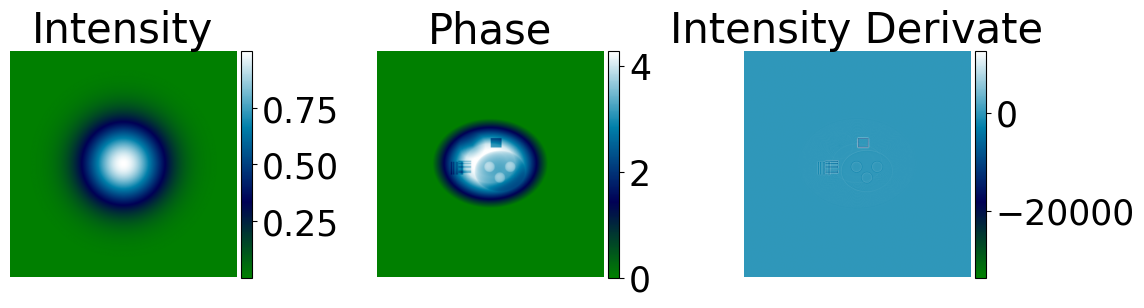

In [11]:
# PARAMETERS
ITER = 100
dz = 2e-6
pixelsize = 2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01



file_path = os.path.join(path_repo, 'data/sim/DeltaPhi_test.mat')
Phase = sio.loadmat(file_path)['Delta_Phi']
Nx,Ny = Phase.shape

x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)
sigma_intensity = 3e-4
Io = cp.exp((-x**2 - y**2) / (2 * sigma_intensity**2))


I0 = cp.asarray(Io)
Phi = cp.asarray(Phase)
# Phi = cp.ones_like(Phase)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

sigma = 1e-12

I0 = cp.asarray(add_gaussian_noise(I0, sigma))

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()


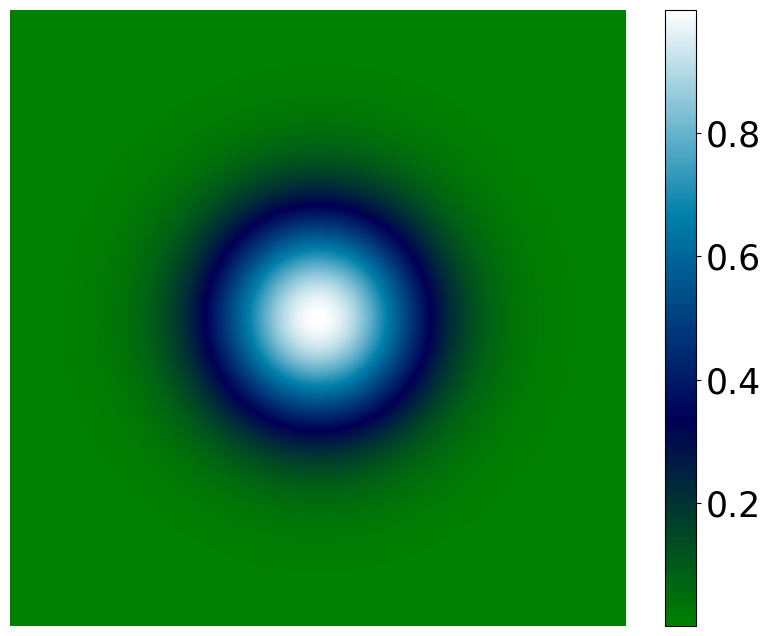

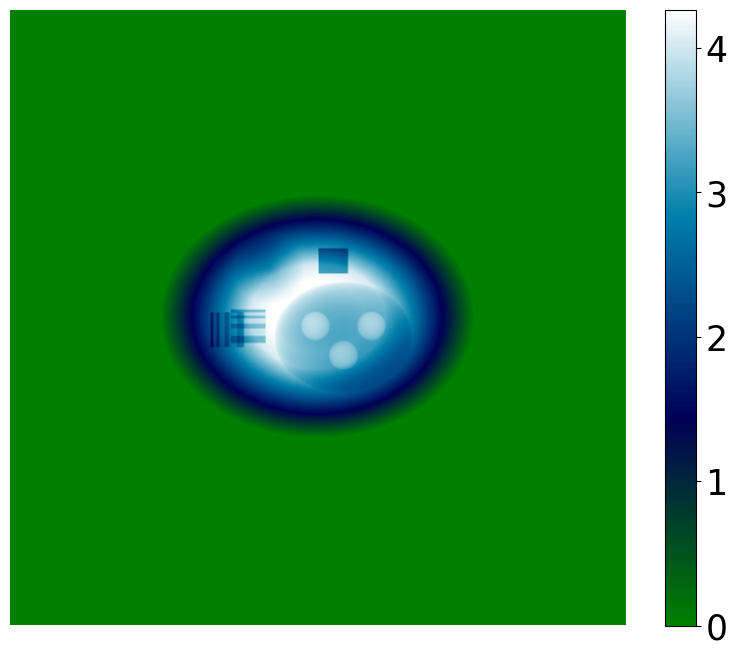

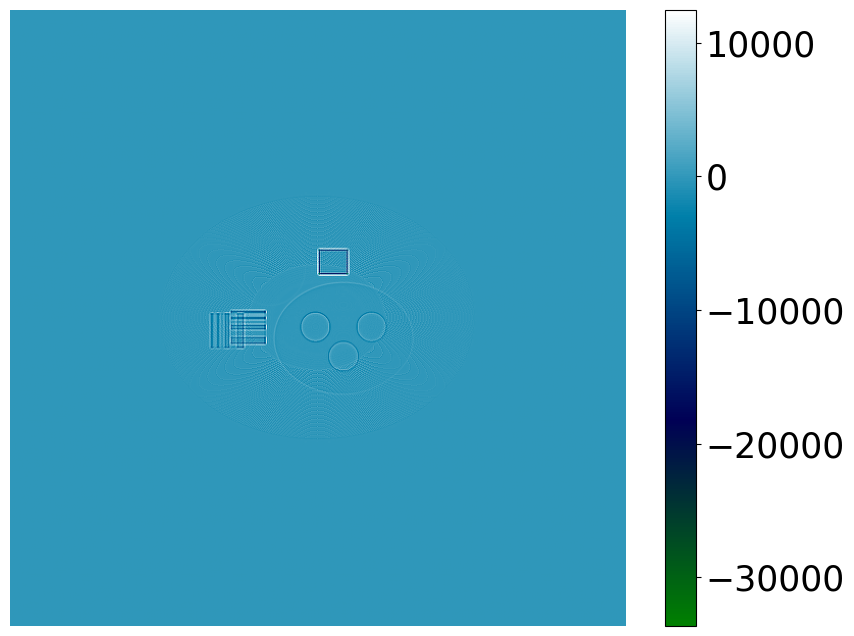

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(I0_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Phi_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(dIdz_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()



1


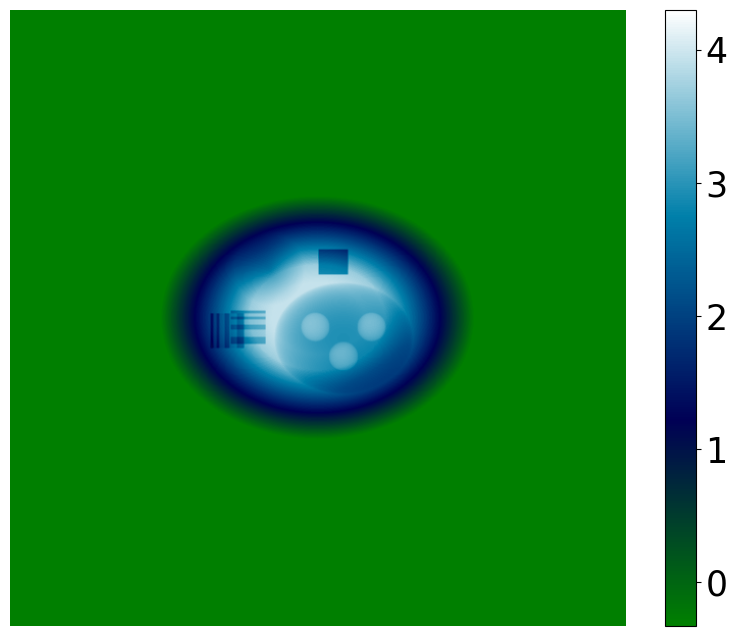

1.8


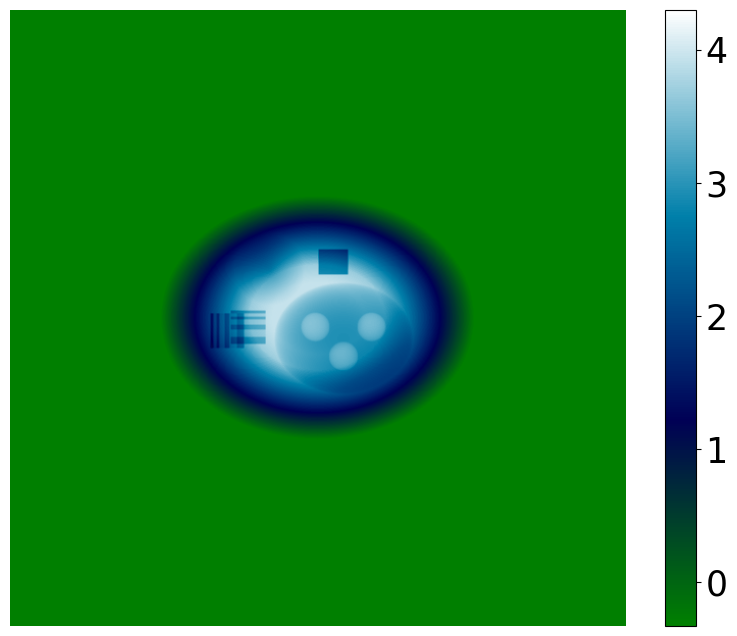

1.95


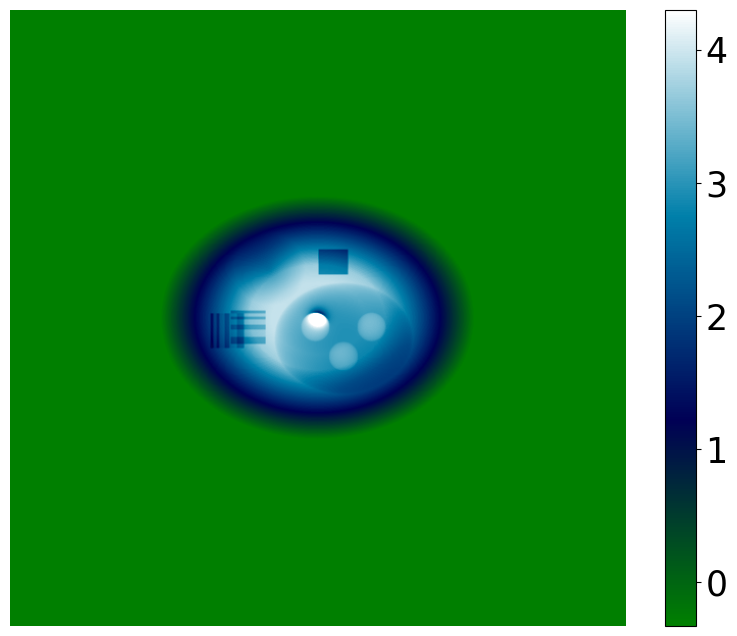

In [13]:
recon_th = {}
error_th = {}
for th in [1,1.8,1.95]:
  Phi_msth_tie, time_msth_tie = MS_TIE_th(I0.copy(), pixelsize, dIdz.copy(), ITER, r, k, th = th)
  recon_th[th] = Phi_msth_tie
  error_th[th] = Phi_msth_tie - Phi
for th in recon_th.keys():
    print(th)
    plt.figure(figsize=(10, 8))
    plt.imshow(recon_th[th].get(), cmap='ocean',vmin = -0.33, vmax = 4.3)
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=25)
    plt.show()


1


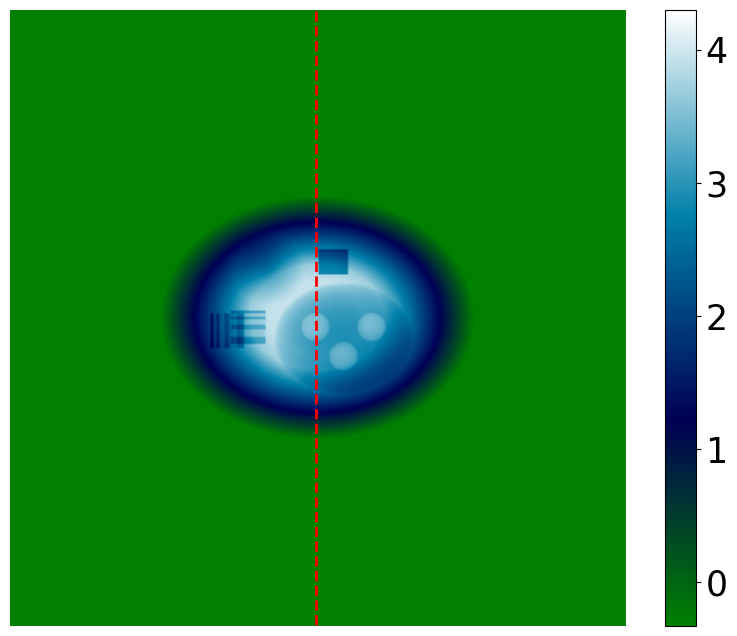

1.8


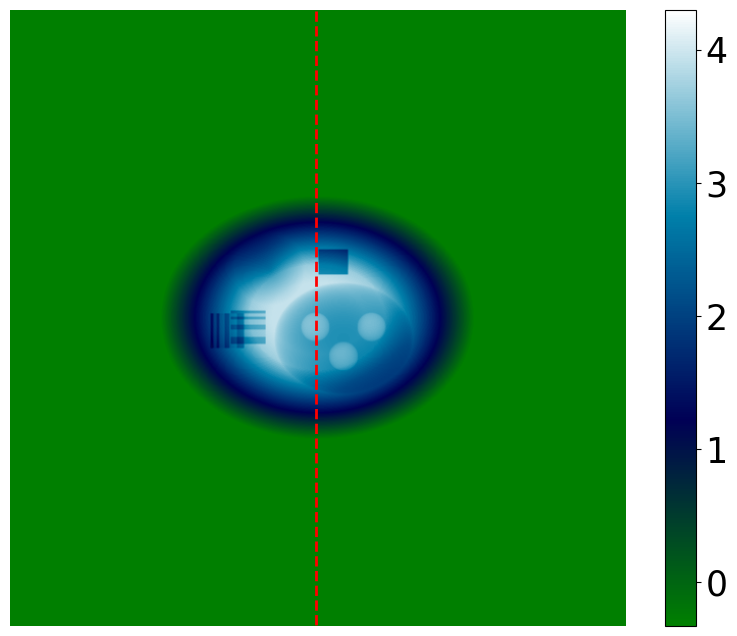

1.95


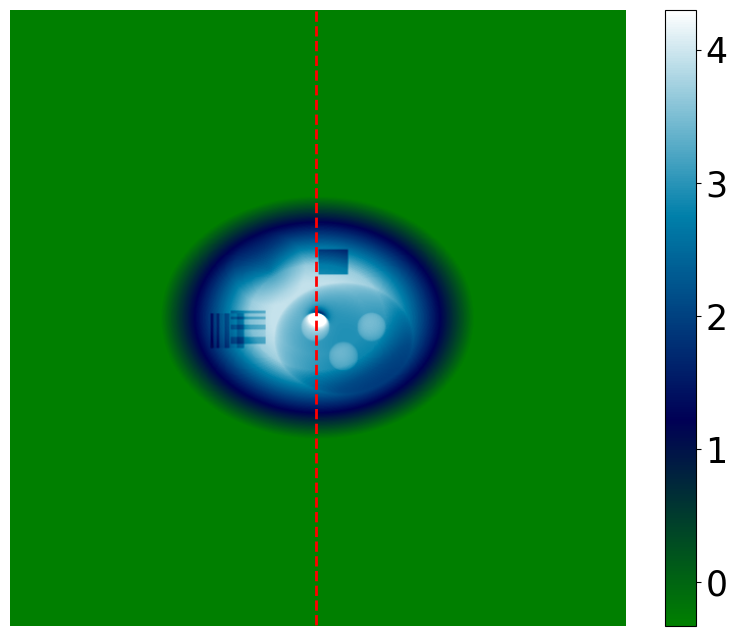

In [14]:
recon_th = {}
error_th = {}
for th in [1,1.8,1.95]:
  Phi_msth_tie, time_msth_tie = MS_TIE_th(I0.copy(), pixelsize, dIdz.copy(), ITER, r, k, th = th)
  recon_th[th] = Phi_msth_tie
  error_th[th] = Phi_msth_tie - Phi
for th in recon_th.keys():
    print(th)
    height, width = I0.get().shape

    # 1. Definir la fila central ("a la mitad de la imagen")
    line_row_index = 300
    plt.figure(figsize=(10, 8))
    plt.imshow(recon_th[th].get(), cmap='ocean',vmin = -0.33, vmax = 4.3)
    plt.plot( [line_row_index, line_row_index],[0, width - 1], color='red', linestyle='--', linewidth=2)
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=25)
    plt.show()


<>:49: SyntaxWarning: invalid escape sequence '\P'
<>:49: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1402616676.py:49: SyntaxWarning: invalid escape sequence '\P'
  plt.ylabel(f'Error: $\Phi - \Phi_T$ (rad)', fontsize=25)


-0.3231838936045598
-0.323183892385995


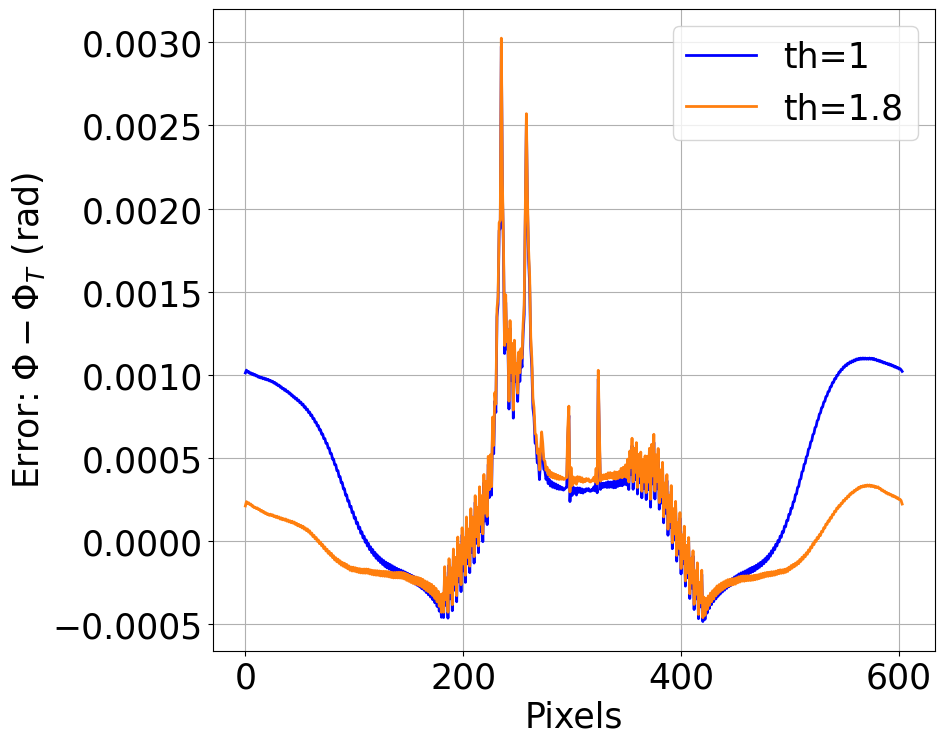

In [15]:
def plot_phase_profiles(recon_data, line_row_index):
    """
    Grafica el perfil horizontal de fase en la línea central para cada caso.
    """
    plt.figure(figsize=(10, 8))

    # 1. Mapeo de colores para los valores de umbral (th)
    color_map = {
        1.0: 'blue',     # Para th = 1
        1.8: 'tab:orange', # 'tab:orange' es un naranja estándar de Matplotlib
        0: 'green'    # Para th = 1.95
    }

    # OPCIÓN para calcular límites Y automáticos con un margen
    all_profiles = []

    # Iterar sobre cada umbral (th) en los resultados
    for th_val in [1,1.8]:

        # Asegurarse de que el umbral esté en el mapa de colores
        if th_val not in color_map:
            print(f"Advertencia: No se encontró un color para th={th_val}. Usando negro.")
            color_to_use = 'black'
        else:
            color_to_use = color_map[th_val]

        # Obtener los datos de la imagen (matriz de fase)
        image_data = -recon_data[th_val].get()
        height, width = image_data.shape

        # 1. Definir la fila central ("a la mitad de la imagen")
        # 2. Extraer el perfil de fase de esa fila
        phase_profile = image_data[:,line_row_index]

        # Guardar el perfil para el cálculo global de límites (para Option 2 de ylim)
        all_profiles.append(phase_profile)

        # 3. Graficar el perfil
        plt.plot(np.arange(height), phase_profile,
                 label=f'th={th_val}',
                 color=color_to_use,
                 linewidth=2)

    # Configuración del gráfico de perfiles

    # 🔥 APLICACIÓN DE FONTSIZE = 25 🔥
    # plt.title('Phase Error Profiles', fontsize=25)
    plt.xlabel('Pixels', fontsize=25)
    plt.ylabel(f'Error: $\Phi - \Phi_T$ (rad)', fontsize=25)

    # Ajustar el tamaño de fuente de la leyenda
    plt.legend(fontsize=25)

    # Ajustar el tamaño de fuente de los ticks de los ejes X e Y
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    # Límites Y fijos según tu último valor proporcionado
    # plt.ylim(0.32, 0.33)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


print(error_th[1].mean())
print(error_th[1.8].mean())

error_th[1.8] = error_th[1.8] - error_th[1.8].mean()
error_th[1] = error_th[1] - error_th[1].mean()

for line_row_index in [300]:
    plot_phase_profiles(error_th, line_row_index) # Debes descomentar esta línea para ejecutar la función

r = 2.220446049250313e-16


/tmp/ipython-input-4174755961.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


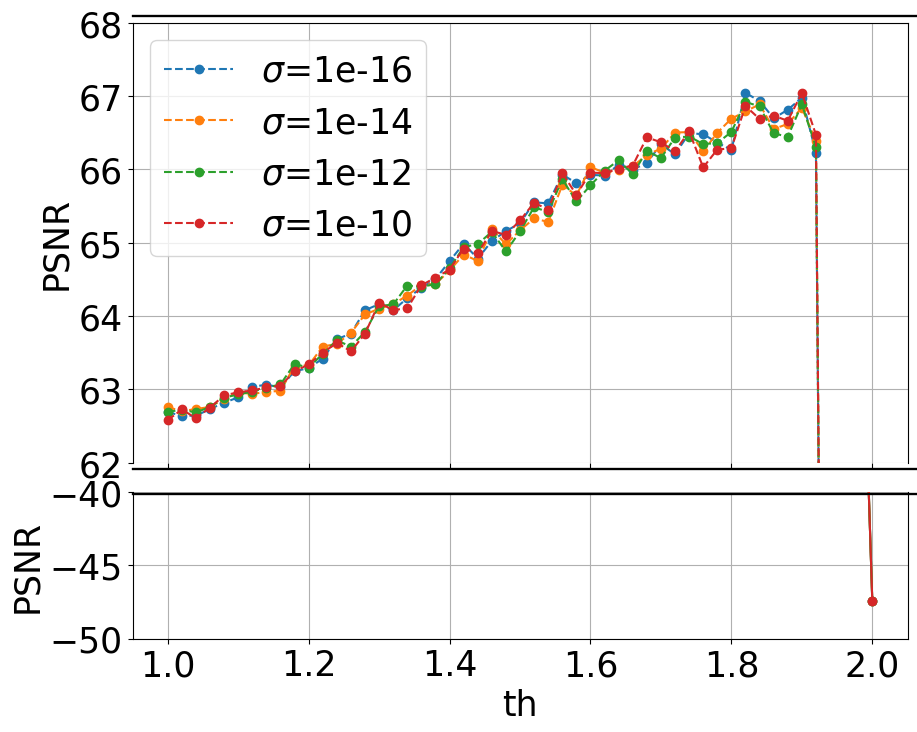

In [16]:

SIGMAS_LIST = np.logspace(-16, -10, num=4)
# ths = np.linspace(1, 2, 10)
ths = np.linspace(1, 2, 51)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8),
                                  gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

print(f'r = {r}')
parameters = dz, pixelsize, k, r, ITER

for sigma in SIGMAS_LIST:

    psnr_values, ssim_values = get_psnr_ssim(I0, Phi, sigma, parameters, ths)
    # Hallo para que valor de ths

    # Eje superior (valores normales)
    ax1.plot(ths, psnr_values, marker='o',linestyle='--', label=rf'$\sigma$={sigma}')
    ax1.set_ylim(62, 68)  # Ajustá según tu rango útil
    ax1.grid(True)
    ax1.legend(fontsize=25)
    ax1.set_ylabel('PSNR', fontsize=25)

    # Eje inferior (solo el outlier negativo)
    ax2.plot(ths, psnr_values, marker='o')
    ax2.set_ylim(-50, -40)
    ax2.grid(True)
    ax2.set_xlabel('th', fontsize=25)
    ax2.set_ylabel('PSNR', fontsize=25)

    # Quitar los bordes del eje roto
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.tick_params(labelbottom=False)

    ax1.tick_params(axis='both', which='major', labelsize=25)  # Números en el eje 1
    ax2.tick_params(axis='both', which='major', labelsize=25)  # Números en el eje 2


    d = .015  # tamaño de la diagonal
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

    # Líneas horizontales en la parte inferior
    ax1.plot((0, 1+d), (-d, -d), **kwargs)  # línea horizontal superior en el eje roto
    ax1.plot((0, 1+d), (1+d, 1+d), **kwargs)  # línea horizontal inferior en el eje roto

    kwargs.update(transform=ax2.transAxes)  # switch de eje

    # Líneas horizontales en la parte superior
    ax2.plot((0, 1+d), (1-d, 1-d), **kwargs)  # línea horizontal superior en el eje roto
    ax2.plot((0, 1+d), (-1-d, -1-d), **kwargs)  # línea horizontal inferior en el eje roto

plt.tight_layout()
plt.show()




<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4041692196.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax1.plot(ths, psnr_values, marker='o', linestyle='--', label=f'$\sigma$={sigma}')


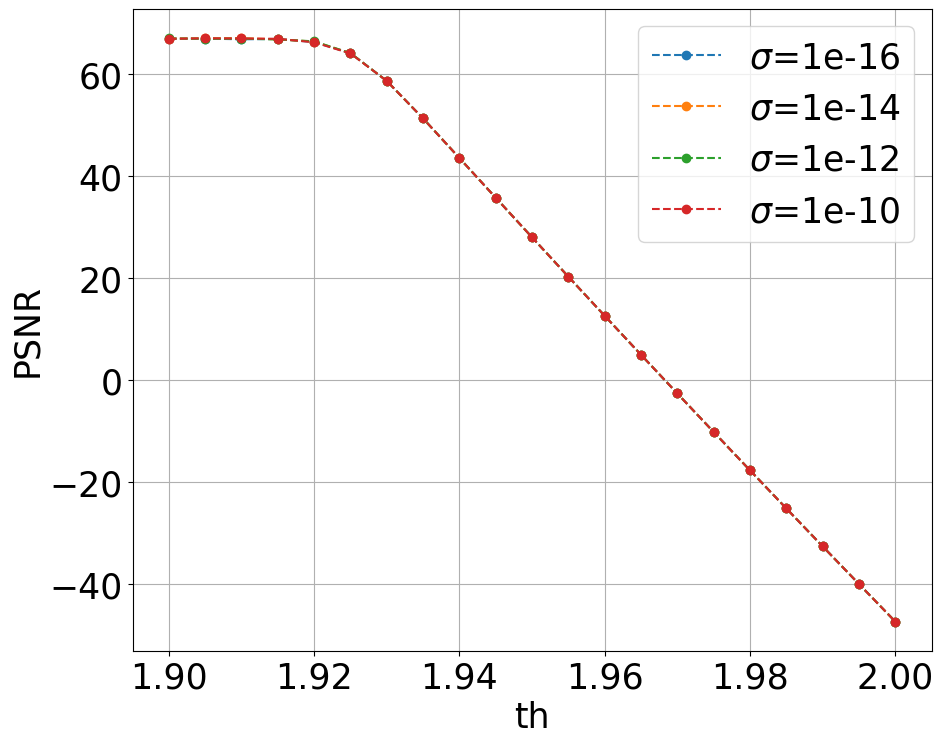

In [17]:


ths = np.linspace(1.9, 2, 21)

fig, ax1 = plt.subplots(figsize=(10, 8))

for sigma in SIGMAS_LIST:

    psnr_values, ssim_values = get_psnr_ssim(I0, Phi, sigma, parameters, ths)
    ax1.plot(ths, psnr_values, marker='o', linestyle='--', label=f'$\sigma$={sigma}')

# Configuración del gráfico
#ax1.set_ylim(60, 70)  # Ajustá según tu rango útil

ax1.grid(True)
ax1.legend(fontsize=25)
ax1.set_ylabel('PSNR', fontsize=25)
ax1.set_xlabel('th', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()
plt.show()


## 2.2.2 Study of the behavior of th > 1.9

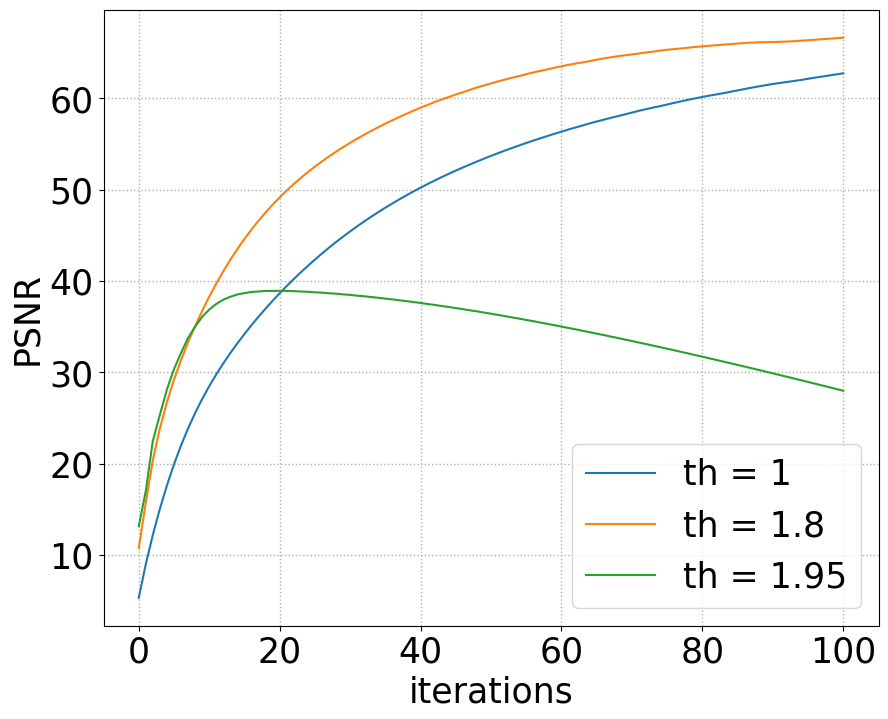

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 8))
psnrs = get_psnrs(I0, pixelsize, dIdz, 100, r,k, th = 1, Phi=cp.asarray(Phi_numpy))
plt.plot(psnrs, label="th = 1")
psnrs = get_psnrs(I0, pixelsize, dIdz, 100, r,k, th = 1.8, Phi=cp.asarray(Phi_numpy))
plt.plot(psnrs, label="th = 1.8")
# psnrs = get_psnrs(I0, pixelsize, dIdz, 100, r,k, th = 1.92, Phi=cp.asarray(Phi_numpy))
# plt.plot(psnrs, label="th = 1.92")
psnrs = get_psnrs(I0, pixelsize, dIdz, 100, r,k, th = 1.95, Phi=cp.asarray(Phi_numpy))
plt.plot(psnrs, label="th = 1.95")
plt.xlabel(r'iterations', fontsize=25)
plt.ylabel(r'PSNR', fontsize=25)
plt.grid(True, linestyle="dotted", linewidth=1)
#plt.title("Behavior of the approximated function for different values of r", fontsize=16)
plt.legend(fontsize=25)
# Ajuste de notación científica para los ejes
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

In [19]:
def track_FJ_evolution(I0, pixelsize, dIdz, FJ0, Iter, r, k, th=1.0):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)

    Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

    omega2 = Cx * Cx + Cy * Cy

    omega_c = (r**(1/4)) / pixelsize
    omega_c1 = omega_c / th
    omega_c2 = omega_c * th

    f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
    f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)

    Filter_tie[:,:,0] = -abs(f).copy()
    Filter_tie[:,:,1] = -abs(f).copy()
    Filter_tie[:,:,2] = -abs(f).copy()

    I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    I[:,:,0] = I0
    I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
    I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

    M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    M[:,:,0] = (Cx * Cx + Cy * Cy)
    M[:,:,1] = Cx
    M[:,:,2] = Cy

    FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
    FJ[:, :, 0] = FJ0.copy() / 3
    FJ[:, :, 1] = FJ0.copy() / 3
    FJ[:, :, 2] = FJ0.copy() / 3
    FJ = Filter_tie * FJ * (-k)

    Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
    M_ones = cp.ones((3, 3), dtype = cp.complex64)

    # List to store FJ snapshots
    fj_snapshots = []

    for n in range(Iter):
        Fphi_curr += FJ
        FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))
        # Store the magnitude of the first channel of FJ
        fj_snapshots.append(cp.abs(FJ[:,:,0]).get())

    return fj_snapshots

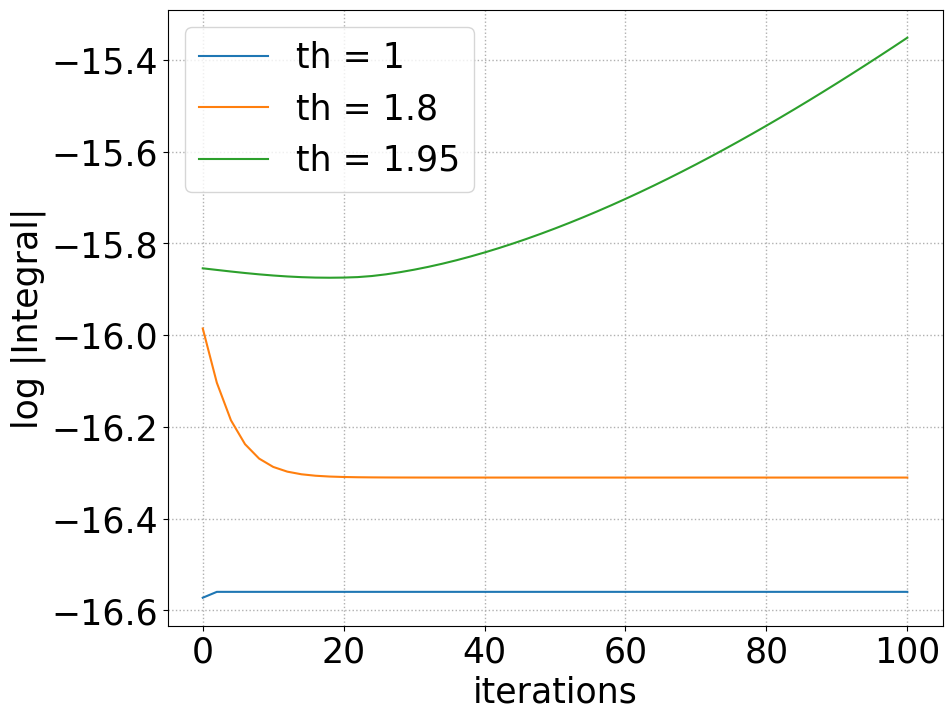

In [20]:
num_iterations_to_plot = 102 # Choose how many iterations to plot
sigma_intensity = 4e-3
Io = cp.exp((-x**2 - y**2) / (2 * sigma_intensity**2))
I0 = cp.asarray(Io)

# Calculate the initial FJ0 from dIdz
Nx, Ny = I0.shape
U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)
omega2 = Cx * Cx + Cy * Cy
omega_c = (r**(1/4)) / pixelsize

# Calculate the initial FJ0 for the default th=1 filter
f_initial = omega2 / (omega2 - 1j*omega_c**2) / (omega2 + 1j*omega_c**2)
f_initial = f_initial * (omega_c**2 + omega_c**2) / (2 * omega_c * omega_c)
filter_initial = -cp.abs(f_initial)
FJ0_initial = cp.fft.ifft2(cp.ones_like(I0))
# FJ0_initial = cp.ones_like(I0)
# sigma_intensity = 3e-3
# FJ0_initial = cp.exp((-x**2 - y**2) / (2 * sigma_intensity**2))



th = 1
fj_snapshots = track_FJ_evolution(I0.copy(), pixelsize, dIdz.copy(), FJ0_initial.copy(), num_iterations_to_plot, r, k, th=th)
integral_1 = np.log10([np.sum(snapshot) for snapshot in fj_snapshots])[::2]
th = 1.8
fj_snapshots = track_FJ_evolution(I0.copy(), pixelsize, dIdz.copy(), FJ0_initial.copy(), num_iterations_to_plot, r, k, th=th)
integral_1_8 = np.log10([np.sum(snapshot) for snapshot in fj_snapshots])[::2]
th = 1.95
fj_snapshots = track_FJ_evolution(I0.copy(), pixelsize, dIdz.copy(), FJ0_initial.copy(), num_iterations_to_plot, r, k, th=th)
integral_1_95 = np.log10([np.sum(snapshot) for snapshot in fj_snapshots])[::2]

iterations = np.arange(0, num_iterations_to_plot, 2)
fig, ax1 = plt.subplots(figsize=(10, 8))
plt.plot(iterations, integral_1, label="th = 1")
plt.plot(iterations, integral_1_8, label="th = 1.8")
plt.plot(iterations, integral_1_95, label="th = 1.95")
plt.xlabel(r'iterations', fontsize=25)
plt.ylabel(r'log |Integral|', fontsize=25)
plt.grid(True, linestyle="dotted", linewidth=1)
#plt.title("Behavior of the approximated function for different values of r", fontsize=16)
plt.legend()
# Ajuste de notación científica para los ejes
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

## Tabla de resultados de simulaciones




### Simulation 1

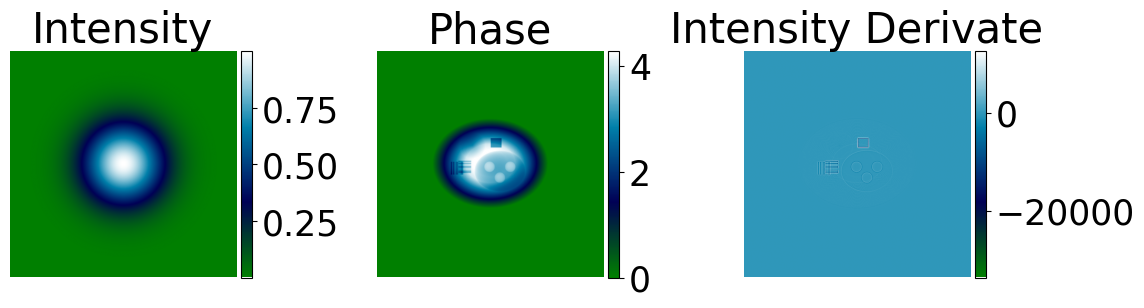

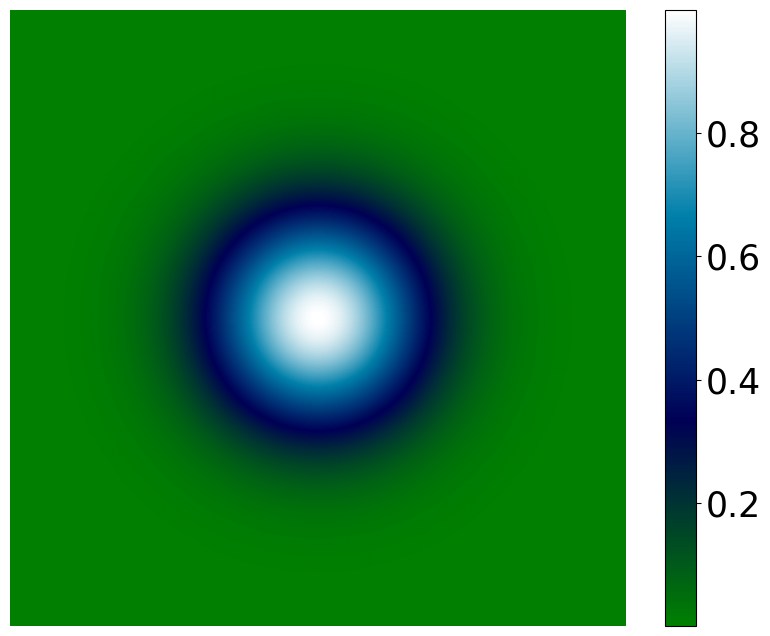

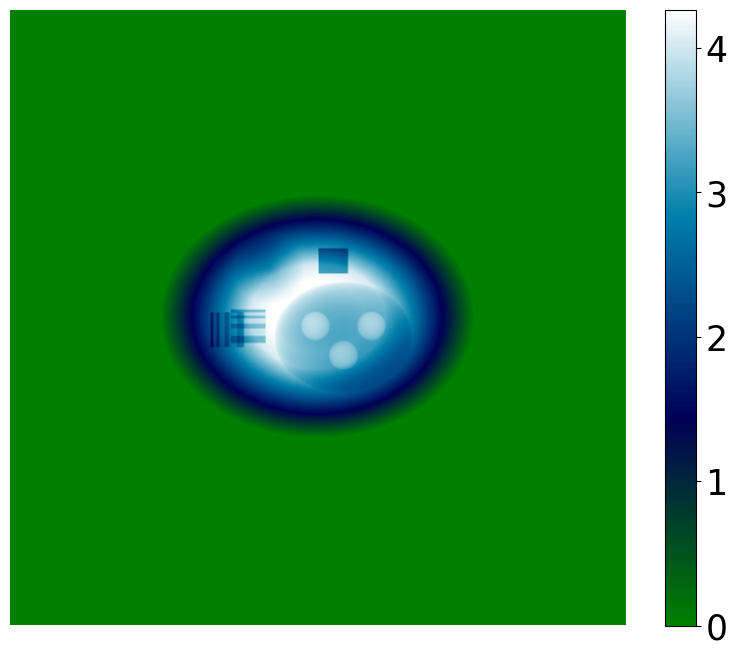

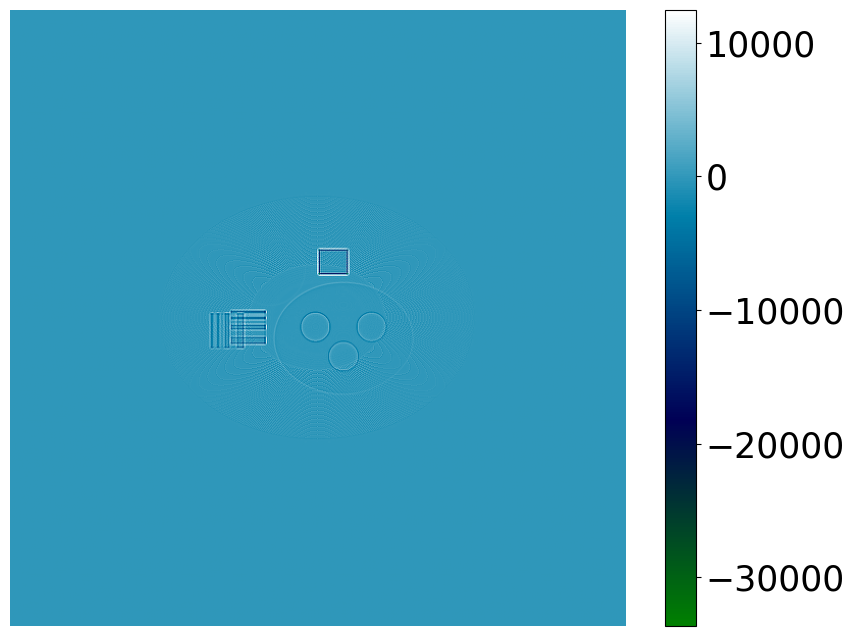

In [21]:
# PARAMETERS
ITER = 100
dz = 2e-6
pixelsize = 2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01



file_path = os.path.join(path_repo, 'data/sim/DeltaPhi_test.mat')
Phase = sio.loadmat(file_path)['Delta_Phi']
Nx,Ny = Phase.shape

x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)
sigma_intensity = 3e-4
Io = cp.exp((-x**2 - y**2) / (2 * sigma_intensity**2))


I0 = cp.asarray(Io)
Phi = cp.asarray(Phase)
# Phi = cp.ones_like(Phase)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

sigma = 1e-12

I0 = cp.asarray(add_gaussian_noise(I0, sigma))

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)



fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(I0_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Phi_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(dIdz_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()



In [22]:

ths = [1,1.8,1.95]

parameters = dz, pixelsize, k, r, ITER
print(f'r = {r}')
sigma = 1e-12

rmse_values_sim1, psnr_values_sim1, ssim_values_sim1, time_values_sim1 = get_rmse_psnr_ssim_time(I0, Phi, sigma, parameters, ths)

print(rmse_values_sim1)
print(psnr_values_sim1)
print(ssim_values_sim1)
print(time_values_sim1)

r = 2.220446049250313e-16
[0.000726905858013047, 0.0004671166983426216, 0.0399234873015584]
[62.77043662443896, 66.61149214820989, 27.975430605370974]
[0.9991517224562751, 0.9998846880398965, 0.9823932898075747]
[0.0525057315826416, 0.06199836730957031, 0.061093807220458984]


### Simulation 2

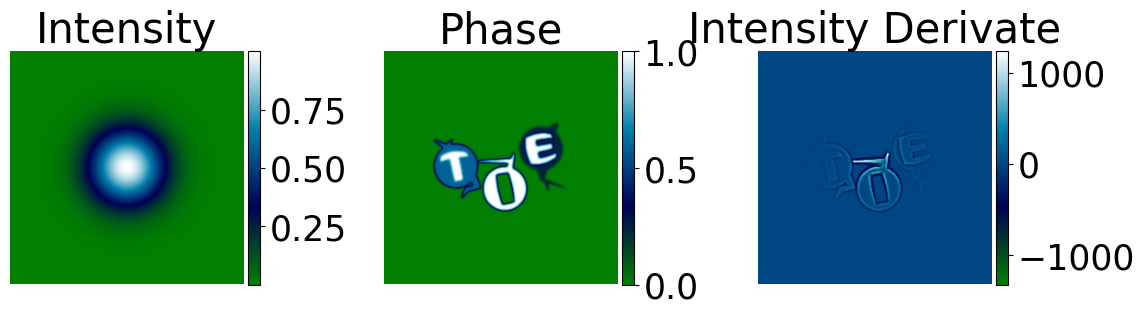

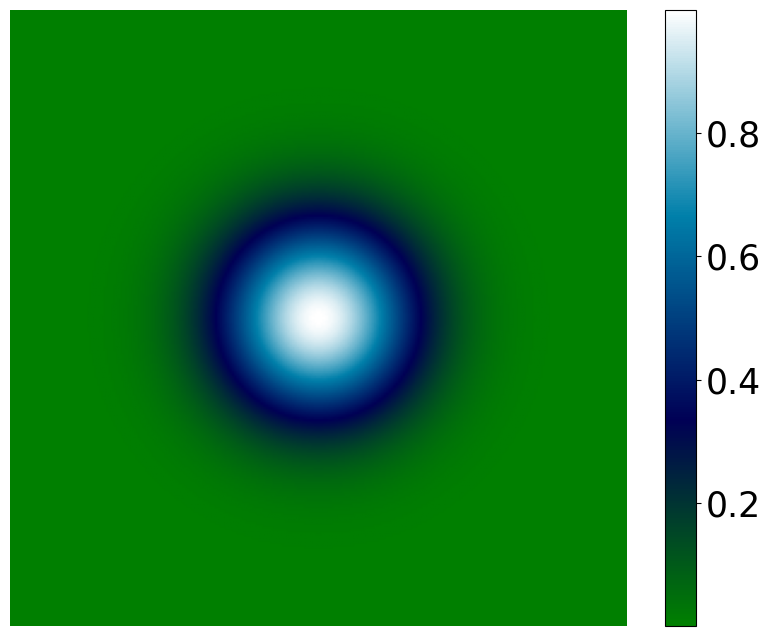

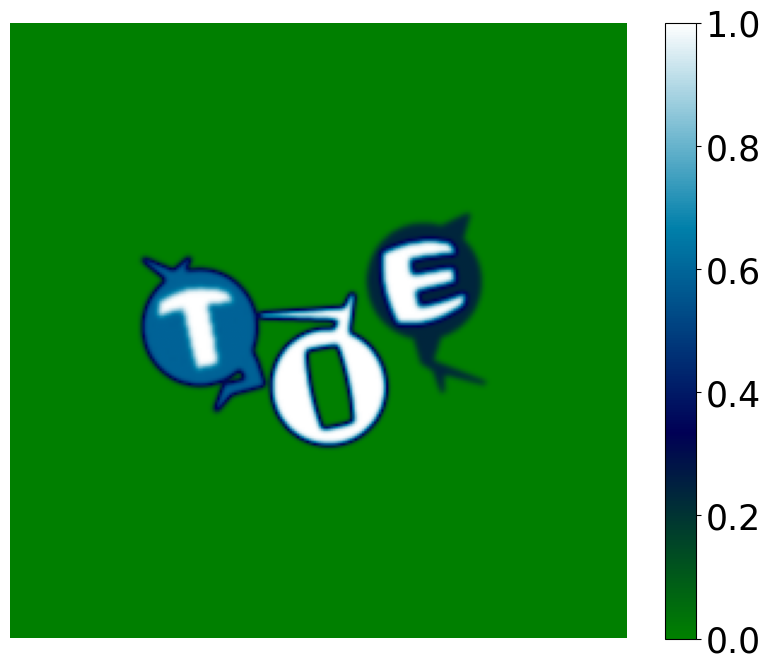

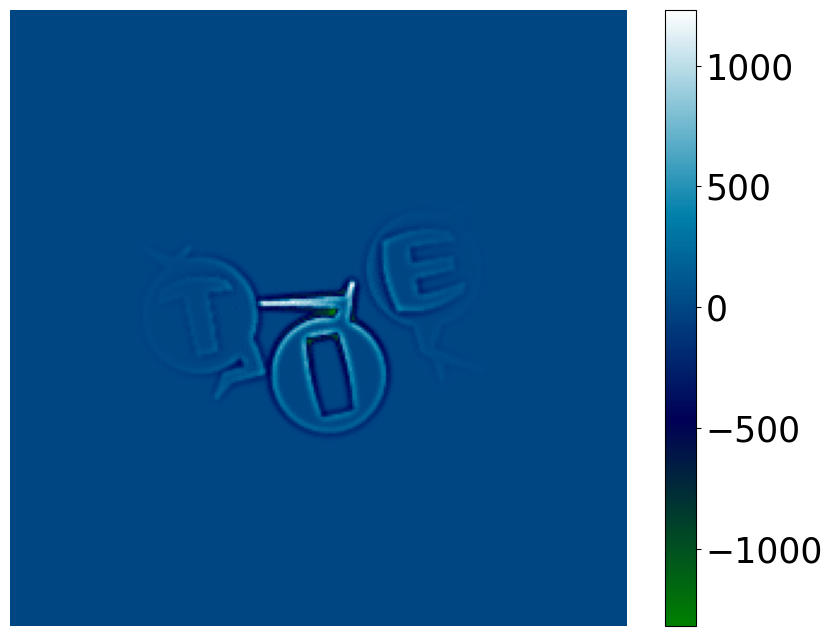

In [23]:
# PARAMETERS
ITER = 100
dz = 2e-6
pixelsize = 5.2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01


file_path_io = os.path.join(path_repo,'data/sim/SCILab_Blur.tif')
file_path_phase = os.path.join(path_repo,'data/sim/TIE_Single_Blur.tif')

Phase = cv2.imread(file_path_phase, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

Nx,Ny = Phase.shape
x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)

sigma_win = 3e-4
Io = cp.exp((-x**2 - y**2) / (2 * sigma_win**2))


x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)


I0 = cp.asarray(Io)
Phi = cp.asarray(Phase)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)


fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(I0_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Phi_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(dIdz_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()



In [24]:

ths = [1,1.8,1.95]

parameters = dz, pixelsize, k, r, ITER
print(f'r = {r}')
sigma = 1e-12

rmse_values_sim2, psnr_values_sim2, ssim_values_sim2, time_values_sim2 = get_rmse_psnr_ssim_time(I0, Phi, sigma, parameters, ths)

print(rmse_values_sim2)
print(psnr_values_sim2)
print(ssim_values_sim2)
print(time_values_sim2)

r = 2.220446049250313e-16
[0.0036955164108916296, 0.0012837204909817155, 0.07224254369115132]
[48.64649729569507, 57.83059052905947, 22.824139414582657]
[0.8623387161300182, 0.9605248678035736, 0.036300560018151996]
[0.16310524940490723, 0.06856417655944824, 0.04504895210266113]


### Simulation 3

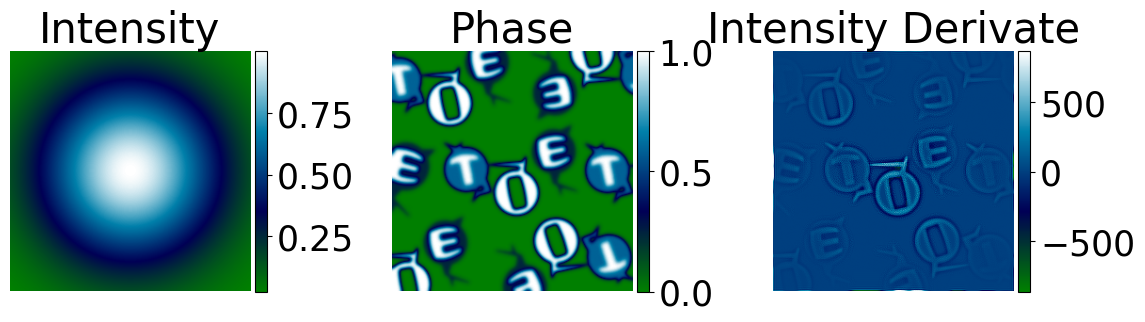

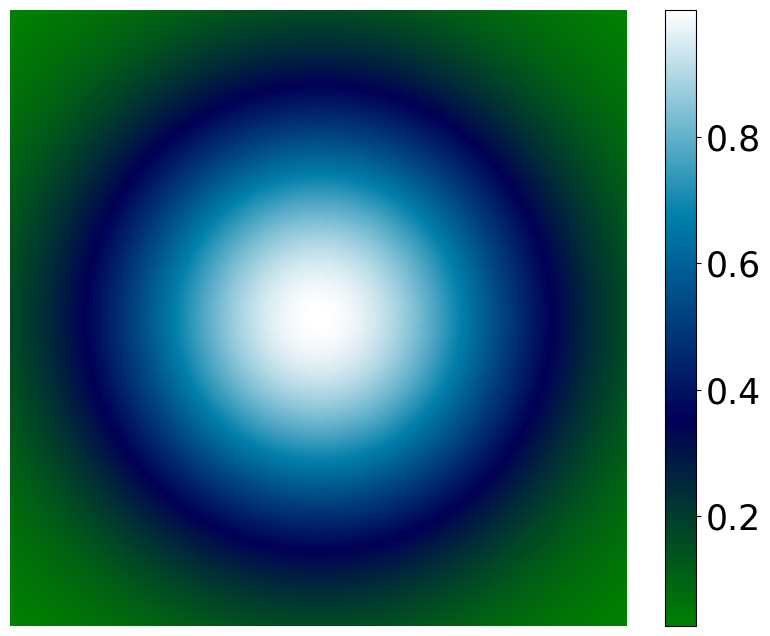

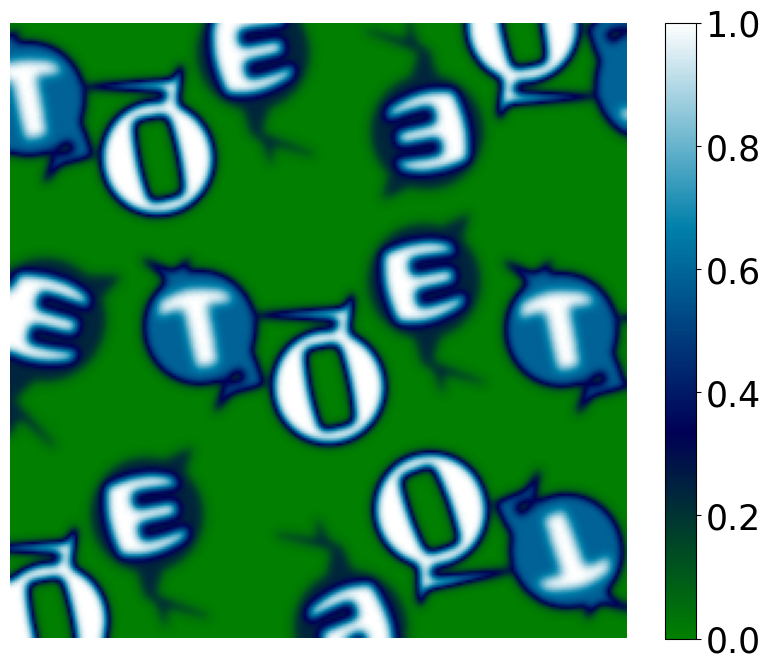

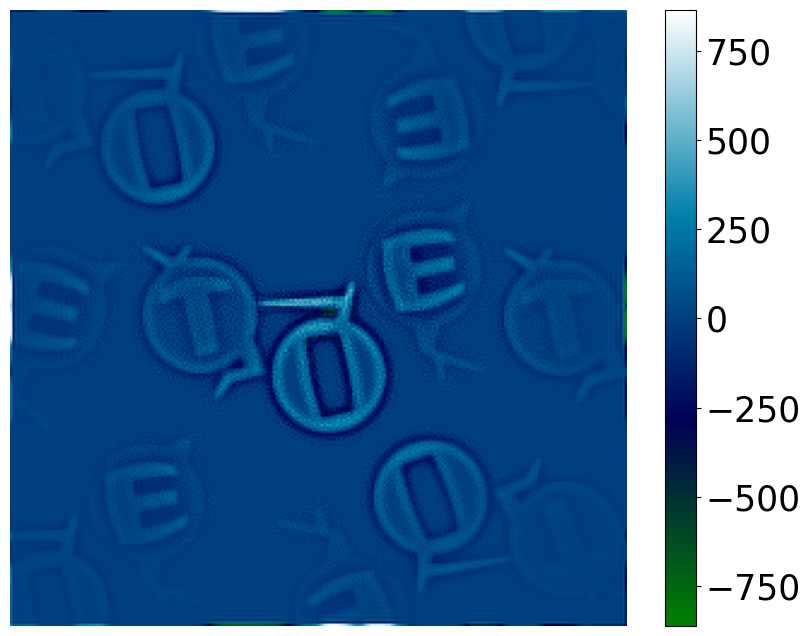

In [28]:
# PARAMETERS
ITER = 100
dz = 3e-6
pixelsize = 5.2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01


file_path_io = os.path.join(path_repo, 'data/sim/SCILab_Blur.tif')
file_path_phase = os.path.join(path_repo, 'data/sim/TIE_Multiple_Blur.tif')

Phase = cv2.imread(file_path_phase, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

Nx,Ny = Phase.shape
x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)

sigma_win = 7e-4
Io = cp.exp((-x**2 - y**2) / (2 * sigma_win**2))


x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)


I0 = cp.asarray(Io)
Phi = cp.asarray(Phase)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(I0_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Phi_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(dIdz_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()



In [29]:

ths = [1,1.8,1.95]

parameters = dz, pixelsize, k, r, ITER
print(f'r = {r}')
sigma = 1e-12

rmse_values_sim3, psnr_values_sim3, ssim_values_sim3, time_values_sim3 = get_rmse_psnr_ssim_time(I0, Phi, sigma, parameters, ths)

print(rmse_values_sim3)
print(psnr_values_sim3)
print(ssim_values_sim3)
print(time_values_sim3)

r = 2.220446049250313e-16
[0.011793347741608546, 0.011324135436162378, 0.19834639484237537]
[38.56725791110922, 38.91989890265894, 14.05151377768538]
[0.6654096102963686, 0.6670699212691188, 0.1190669568504924]
[0.04626727104187012, 0.04328584671020508, 0.043264150619506836]


### Simulation 4

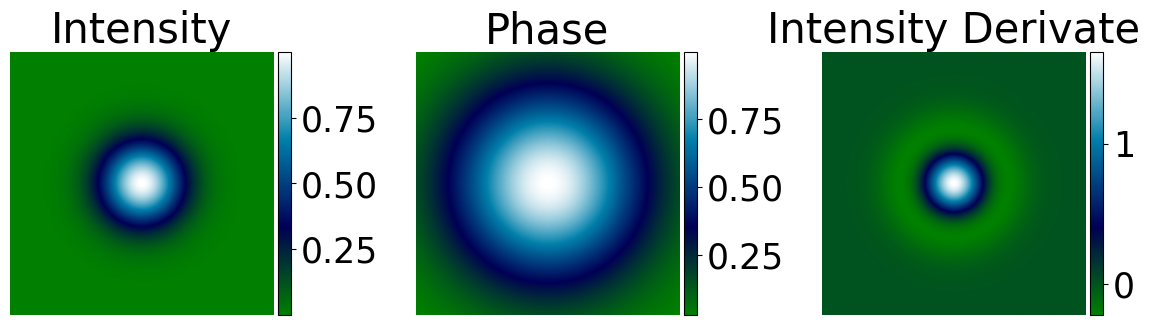

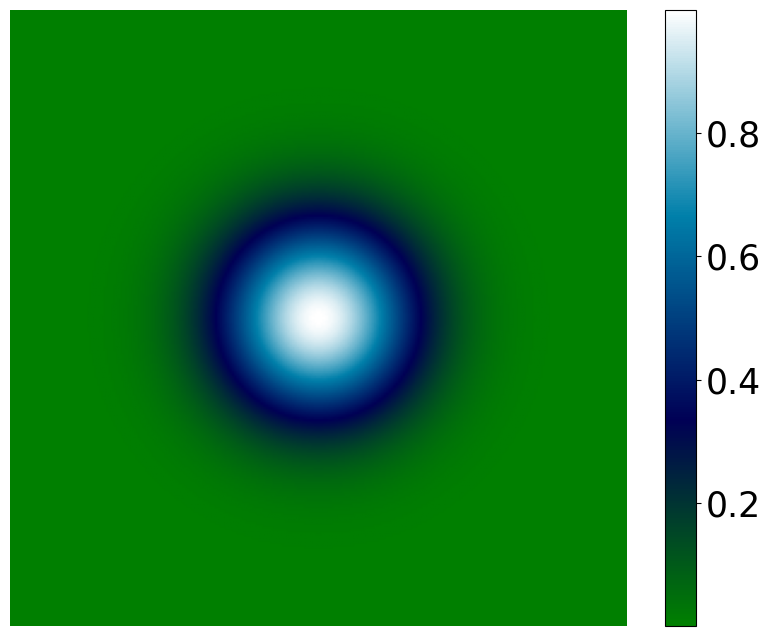

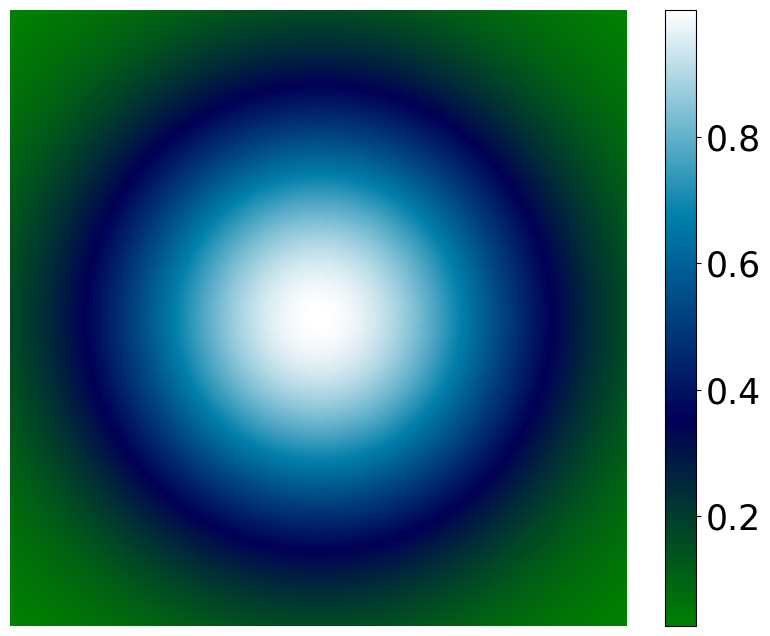

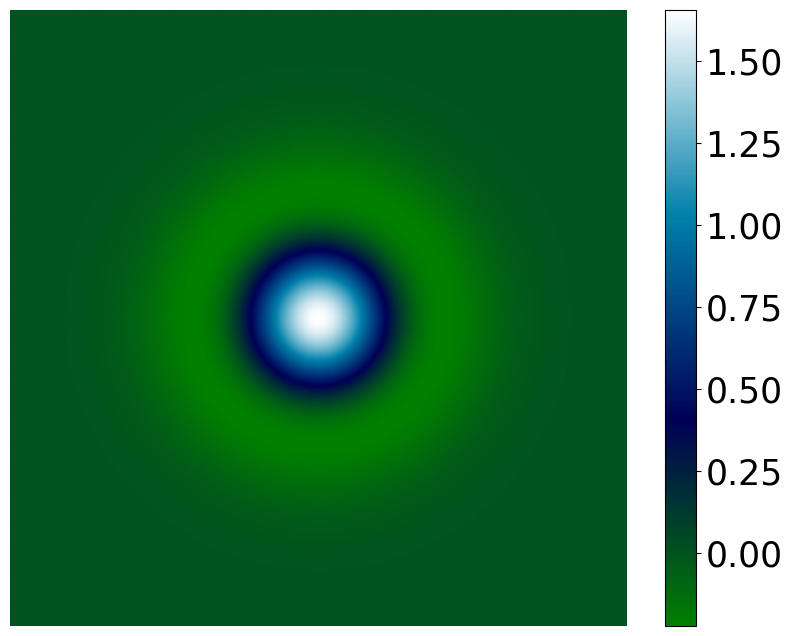

In [30]:
# PARAMETERS
ITER = 100
dz = 3e-6
pixelsize = 5.2e-6
lambda_ = 633e-9
k = 2 * cp.pi / lambda_
r = cp.finfo(float).eps
IntThr = 0.01


sigma_phi = 7e-4
Phi = cp.exp((-x**2 - y**2) / (2 * sigma_phi**2))

Nx,Ny = Phase.shape
x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)

sigma_win = 3e-4
Io = cp.exp((-x**2 - y**2) / (2 * sigma_win**2))


x, y = cp.meshgrid(cp.linspace(-1, 1, Nx) * pixelsize * Nx, cp.linspace(-1, 1, Ny) * pixelsize * Ny)


I0 = cp.asarray(Io)
Phi = cp.asarray(Phi)

U0z = cp.sqrt(I0) * cp.exp(1j * Phi)
Uz, Iz = numerical_propagation(U0z, dz, pixelsize, lambda_, 'Angular Spectrum')
method_retrieve= 'TIE'

dIdz = (Iz - I0) / dz

I0_numpy = cp.asnumpy(I0)
Phi_numpy = cp.asnumpy(Phi)
dIdz_numpy = cp.asnumpy(dIdz)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Intensity
im0 = ax[0].imshow(I0_numpy, cmap='ocean')
ax[0].set_title('Intensity')
ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

# Phase
im1 = ax[1].imshow(Phi_numpy, cmap='ocean')
ax[1].set_title('Phase')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Intensity Derivate
im2 = ax[2].imshow(dIdz_numpy, cmap='ocean')
ax[2].set_title('Intensity Derivate')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

plt.tight_layout()
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(I0_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(Phi_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()

print()

plt.figure(figsize=(10, 8))
plt.imshow(dIdz_numpy, cmap='ocean')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()



In [31]:

ths = [1,1.8,1.95]

parameters = dz, pixelsize, k, r, ITER
print(f'r = {r}')
sigma = 1e-12

rmse_values_sim4, psnr_values_sim4, ssim_values_sim4, time_values_sim4 = get_rmse_psnr_ssim_time(I0, Phi, sigma, parameters, ths)

print(rmse_values_sim4)
print(psnr_values_sim4)
print(ssim_values_sim4)
print(time_values_sim4)

r = 2.220446049250313e-16
[0.11579077381179491, 0.10098693774027549, 0.09763642516113732]
[18.726520874737467, 19.914695937057083, 20.207762602551604]
[0.3535615596737936, 0.39438733047765495, 0.4005170652522892]
[0.05507016181945801, 0.04414033889770508, 0.04416370391845703]


### Simulations - table

In [32]:
# 1. Definir los nombres de las filas
simulaciones = ['Simulación 1', 'Simulación 2', 'Simulación 3']
thresholds = [1.0, 1.8, 1.95] # Usa flotantes para th

# 2. Crear una lista de tuplas para el índice MultiIndex (Simulación, th)
index_tuples = []
for sim in simulaciones:
    for th in thresholds:
        index_tuples.append((sim, th))

# 3. Concatenar todos los valores de las listas por métrica (columna)
data = {
    'RMSE': rmse_values_sim1 + rmse_values_sim2 + rmse_values_sim3,
    'PSNR': psnr_values_sim1 + psnr_values_sim2 + psnr_values_sim3,
    'SSIM': ssim_values_sim1 + ssim_values_sim2 + ssim_values_sim3,
    'Tiempo': time_values_sim1 + time_values_sim2 + time_values_sim3,
}

# 4. Crear el DataFrame
df = pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index_tuples, names=['Simulación', 'th']))

# 5. Imprimir la tabla
print(df)

                       RMSE       PSNR      SSIM    Tiempo
Simulación   th                                           
Simulación 1 1.00  0.000727  62.770437  0.999152  0.052506
             1.80  0.000467  66.611492  0.999885  0.061998
             1.95  0.039923  27.975431  0.982393  0.061094
Simulación 2 1.00  0.003696  48.646497  0.862339  0.163105
             1.80  0.001284  57.830591  0.960525  0.068564
             1.95  0.072243  22.824139  0.036301  0.045049
Simulación 3 1.00  0.011793  38.567258  0.665410  0.046267
             1.80  0.011324  38.919899  0.667070  0.043286
             1.95  0.198346  14.051514  0.119067  0.043264


## Graph iteraciones vs psnr para varios th




In [33]:
import plotly.graph_objects as go
import numpy as np

# Reuse the PSNR calculation from the previous step
# 1. Define parameters
ITERATIONS_TO_PLOT = 100  # Number of iterations to consider for the plot
ths_to_plot = np.linspace(1, 2, 21) # Range of th values to explore

# 2. Calculate PSNR values
psnr_data = []
for th in ths_to_plot:
    # Get PSNR values for a given th across iterations
    psnrs_for_th = get_psnrs(I0.copy(), pixelsize, dIdz.copy(), ITERATIONS_TO_PLOT, r, k, th=th, Phi=cp.asarray(Phi_numpy.copy()))
    psnr_data.append(psnrs_for_th)

# Convert list of lists to a numpy array
psnr_data = np.array(psnr_data)

# 3. Prepare data for Plotly
# Plotly expects x, y, and z to be 2D arrays
iterations_grid, th_grid = np.meshgrid(np.arange(1, ITERATIONS_TO_PLOT + 2), ths_to_plot)
psnr_grid = psnr_data


In [34]:
# 4. Generate interactive 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=psnr_grid, x=iterations_grid, y=th_grid)])

# Update layout for better readability
fig.update_layout(
    title='Interactive PSNR vs Iterations and th',
    scene = dict(
        xaxis_title='Iterations',
        yaxis_title='th',
        zaxis_title='PSNR'
    ),
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(l=65, r=50, b=65, t=90)
)

# 5. Visualize the plot
fig.show()

In [35]:
# Ensure I0, pixelsize, dIdz, ITER, r, and k are available from previous calculations
# Also ensure the modified track_FJ_evolution function is defined
import plotly.graph_objects as go # Import plotly here
import numpy as np

ths_to_visualize = np.linspace(1, 2, 21) # Range of th values to explore

num_iterations_to_plot = 100 # Choose how many iterations to plot

# Calculate the initial FJ0 from dIdz
Nx, Ny = I0.shape
U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)
omega2 = Cx * Cx + Cy * Cy
omega_c = (r**(1/4)) / pixelsize

# Calculate the initial FJ0 for the default th=1 filter
f_initial = omega2 / (omega2 - 1j*omega_c**2) / (omega2 + 1j*omega_c**2)
f_initial = f_initial * (omega_c**2 + omega_c**2) / (2 * omega_c * omega_c)
filter_initial = -cp.abs(f_initial)
# FJ0_initial = cp.fft.ifft2(cp.ones_like(I0))
# FJ0_initial = cp.ones_like(I0)
sigma_intensity = 3e-1
FJ0_initial = cp.exp((-x**2 - y**2) / (2 * sigma_intensity**2))


sumas_data = []

for th in ths_to_visualize:
    print(f"Generating plots for th = {th}")
    # Get the FJ snapshots for the current th
    # Using the calculated FJ0_initial for consistency
    fj_snapshots = track_FJ_evolution(I0.copy(), pixelsize, dIdz.copy(), FJ0_initial.copy(), num_iterations_to_plot, r, k, th=th)

    sumas = []
    for snapshot in fj_snapshots:
        sumas.append(np.sum(snapshot))

    sumas_data.append(np.log10(sumas))

    # Convert list of lists to a numpy array
sumas_data = np.array(sumas_data)

# 3. Prepare data for Plotly
# Plotly expects x, y, and z to be 2D arrays
iterations_grid, th_grid = np.meshgrid(np.arange(1, num_iterations_to_plot + 2), ths_to_visualize)

# 4. Generate interactive 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=sumas_data, x=iterations_grid, y=th_grid)])

# Update layout for better readability
fig.update_layout(
    title='Interactive SUM vs Iterations and th',
    scene = dict(
        xaxis_title='Iterations',
        yaxis_title='th',
        zaxis_title='Integral'
    ),
    autosize=False,
    width=700,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90)
)

# 5. Visualize the plot
fig.show()
    # plt.plot(sumas)
    # plt.show()
    # # Plot the magnitude of FJ for each snapshot
    # for i, fj_magnitude in enumerate(fj_snapshots):
    #     plt.figure(figsize=(8, 6))
    #     plt.imshow(np.log10(np.fft.ifftshift(fj_magnitude)+1e-16), cmap='viridis')
    #     plt.colorbar(label='log10(|FJ|)')
    #     plt.title(f'|FJ| Evolution (th={th}, Iteration {i+1})')
    #     plt.xlabel('Frequency (fx)')
    #     plt.ylabel('Frequency (fy)')
    #     plt.show()

Generating plots for th = 1.0
Generating plots for th = 1.05
Generating plots for th = 1.1
Generating plots for th = 1.15
Generating plots for th = 1.2
Generating plots for th = 1.25
Generating plots for th = 1.3
Generating plots for th = 1.35
Generating plots for th = 1.4
Generating plots for th = 1.45
Generating plots for th = 1.5
Generating plots for th = 1.55
Generating plots for th = 1.6
Generating plots for th = 1.65
Generating plots for th = 1.7000000000000002
Generating plots for th = 1.75
Generating plots for th = 1.8
Generating plots for th = 1.85
Generating plots for th = 1.9
Generating plots for th = 1.9500000000000002
Generating plots for th = 2.0
